***Andrew Plum***<br/>
***CS 474***<br/>
***11/18/2024***

## HW 5: Build a many-to-one RNN for sentiment analysis

In this homework, you will build a many-to-one RNN for sentiment analysis, i.e., classify reviews into two categories: positive (1) and negative(0).

**Dataset**: 

    -IMDb Movie Reviews for binary sentiment classification
    -A set of 50,000 reviews with labels. All reviews have been cleaned.

In [47]:
#Feel free to import other necassary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import time

from tqdm import tqdm # you may need to install this package
tqdm.pandas()
from collections import Counter

# used keras as professor said we could
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping


#### 1. Load the dataset
In the my_imdb.csv file, the 'review' column has preprocessed texts of user reviews, and the 'label' has binary catogories. 1 indicates positive comments, and 0 means negative comments.

In [3]:
# read processed data
df = pd.read_csv('my_imdb.csv')
print(df.shape)
df.head()

(50000, 2)


,review,label
0,One reviewer mentioned watching Oz episode hoo...,1
1,A wonderful little production . The filming te...,1
2,I thought wonderful way spend time hot summer ...,1
3,Basically family little boy Jake think zombie ...,0
4,Petter Mattei Love Time Money visually stunnin...,1


#### 2. Text vectorization
Text vectorization converts texts into sequences of numeric values

- The **vocabulary** is a set that contains all unique words in the dataset.
- The **vectorizer** is dictionary that contains every word in the vocabulary set and its index
- The **padding** creates vectors with fixex length, e.g., 256
- Feel free to change the following code to use other text vectorization approaches, e.g., TF-IDF or BoW.

2.1 Create the vocabulary and the vectorizer

In [6]:
# get all words
text = df.review.values
words = ' '.join(text)
words = words.split() 

# build vocabulary
vocab = sorted(Counter(words), key=Counter(words).get, reverse=True)
ID2W = dict(enumerate(vocab, 1))
ID2W[0] = '<PAD>' # special word for paddding purpose, and the index is 0
vectorizer = {word: ID for ID, word in ID2W.items()}
vectorizer

{'.': 1,
 ',': 2,
 'I': 3,
 '-': 4,
 'movie': 5,
 'film': 6,
 'The': 7,
 'one': 8,
 '!': 9,
 'like': 10,
 'It': 11,
 '?': 12,
 'time': 13,
 'This': 14,
 'good': 15,
 'character': 16,
 'story': 17,
 'would': 18,
 'get': 19,
 'make': 20,
 'see': 21,
 'really': 22,
 'even': 23,
 'scene': 24,
 'much': 25,
 'well': 26,
 'people': 27,
 'bad': 28,
 'great': 29,
 'way': 30,
 'show': 31,
 'made': 32,
 'thing': 33,
 'first': 34,
 'also': 35,
 'could': 36,
 'think': 37,
 'life': 38,
 'But': 39,
 'know': 40,
 'go': 41,
 'And': 42,
 'plot': 43,
 'seen': 44,
 'actor': 45,
 'watch': 46,
 'A': 47,
 'say': 48,
 'year': 49,
 'love': 50,
 'many': 51,
 'end': 52,
 'two': 53,
 'acting': 54,
 'look': 55,
 'never': 56,
 'There': 57,
 'In': 58,
 'little': 59,
 'best': 60,
 'ever': 61,
 'better': 62,
 'work': 63,
 'If': 64,
 'take': 65,
 'come': 66,
 'He': 67,
 'find': 68,
 'man': 69,
 'part': 70,
 'still': 71,
 'something': 72,
 'want': 73,
 'give': 74,
 'back': 75,
 'lot': 76,
 'real': 77,
 'performance': 78

2.2 Sample results of vectorization

In [8]:
print('Text sample:', text[0])
num_vec = [vectorizer[w] for w in text[0].split()]
print('Coverted vector:',  len(num_vec), num_vec,)

Text sample: One reviewer mentioned watching Oz episode hooked . They right , exactly happened . The first thing struck Oz brutality unflinching scene violence , set right word GO . Trust , show faint hearted timid . This show pull punch regard drug , sex violence . Its hardcore , classic use word . It called OZ nickname given Oswald Maximum Security State Penitentary . It focus mainly Emerald City , experimental section prison cell glass front face inwards , privacy high agenda . Em City home many . . Aryans , Muslims , gangsta , Latinos , Christians , Italians , Irish . . . . scuffle , death stare , dodgy dealing shady agreement never far away . I would say main appeal show due fact go show dare . Forget pretty picture painted mainstream audience , forget charm , forget romance . . . OZ mess around . The first episode I ever saw struck nasty surreal , I say I ready , I watched , I developed taste Oz , got accustomed high level graphic violence . Not violence , injustice crooked guard

2.3 Apply vectorization to the whole dataset
- Apply padding to create sequences with fixed length
- The final dataset with with numeric features is (X, Y)

In [10]:
# text vectorization and padding
vecs = [[vectorizer[w] for w in r.split()] for r in tqdm(text)] # vecs contains the vectorized reviews of varying length
seq_length = 256
    
X = np.full((len(vecs), seq_length), 0, dtype=int) # create matrix whose shape is (50000, 256) initialized with 0
for i, vec in enumerate(vecs): 
    X[i, :len(vec)] = np.array(vec)[:seq_length] # of each vectorized review, grab only up to the first 256 values and store in the row of X

print('Text vectors:', X.shape)
Y = df.label.to_numpy()
print('Labels:', Y.shape)

100%|█████████████████████████████████████████████████████████████████████████| 50000/50000 [00:03<00:00, 13908.89it/s]


Text vectors: (50000, 256)
Labels: (50000,)


In [11]:
print('Original vector:\n', vec[0])
print('Results with padding:\n', X[0])

Original vector:
 291
Results with padding:
 [  191  1083   930    81  3724   186  3030     1   118   114     2   527
   500     1     7    34    33  3086  3724  5192 15234    24   490     2
   126   114   259  7473     1  5550     2    31  6620  2169 11285     1
    14    31   923  2106  2177   591     2   289   490     1   677  3805
     2   242   262   259     1    11   342  9227 10121   279 14927 22637
 12715  4100 55917     1    11   758  1332 29362  1094     2  4665  1963
  1105  2317  2079   822   243 55918     2 16586   237  4338     1 18349
  1094   261    51     1     1 25451     2  8327     2 12516     2 15235
     2  5060     2  7897     2  2344     1     1     1     1 22638     2
   251  4076     2  7347  1674  8574  9867    56   144   160     1     3
    18    48   193  1066    31   587    96    41    31  2759     1  4156
   106   281  4057  2373   166     2   798  1179     2   798   740     1
     1     1  9227   793   100     1     7    34   186     3    61   130
  3086

## Keras Implementation - Professor said we could implement using keras

#### 3. Prepare the training, validation and test sets. 15 points
- Use 50% data for training, 20% for validation, and 30% for testing
- Set the batch size to 128

In [14]:
# Split the data

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.5, random_state = 0)
X_validation, X_test, Y_validation, Y_test = train_test_split(X_test, Y_test, test_size = 0.6, random_state = 0)

print("Training set:")
print(X_train.shape)
print(Y_train.shape)
print()
print("Validation set:")
print(X_validation.shape)
print(Y_validation.shape)
print()
print("Test set:")
print(X_test.shape)
print(Y_test.shape)
print()

# batch size set in next cell with other hyperparameters


Training set:
(25000, 256)
(25000,)

Validation set:
(10000, 256)
(10000,)

Test set:
(15000, 256)
(15000,)



#### 4. Build a many-to-one RNN. 40 points
- GRU or LSTM is preferred

In [49]:
vocab_size = X_train.max() + 1 
embedding_size = 32
hidden_size = 32
output_size = 1
batch_size = 128
lr = 0.001

learning_rate_reduction = ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 1, verbose = 1)
early_stop = EarlyStopping(monitor = "val_loss", patience = 4, verbose = 1)
checkpoint = ModelCheckpoint("Best_Model.h5", save_best_only = True, mode = "min", monitor = "val_loss", verbose = 1) 
#callbacks = [learning_rate_reduction, checkpoint, early_stop]
callbacks = [checkpoint, early_stop]

# build keras LSTM RNN

LSTM_RNN = Sequential()

LSTM_RNN.add(Embedding(input_dim = vocab_size, output_dim = embedding_size))

LSTM_RNN.add(Bidirectional(LSTM(hidden_size)))
#LSTM_RNN.add(LSTM(hidden_size, dropout = 0.2, recurrent_dropout = 0.2))
#LSTM_RNN.add(LSTM(hidden_size))
#LSTM_RNN.add(LSTM(hidden_size, return_sequences = True, dropout = 0.1, recurrent_dropout = 0.1))
#LSTM_RNN.add(LSTM(hidden_size, dropout = 0.1, recurrent_dropout = 0.1))

LSTM_RNN.add(Dense(output_size, activation = "sigmoid")) 

LSTM_RNN.compile(optimizer = Adam(learning_rate = lr), 
                 loss = "binary_crossentropy", 
                 metrics = ["accuracy"]
                )
LSTM_RNN.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 32)          3881632   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 3,898,337
Trainable params: 3,898,337
Non-trainable params: 0
_________________________________________________________________


#### 5. Train the above model. 30 points

Epoch 1/20
196/196 [==============================] - ETA: 0s - loss: 0.5572 - accuracy: 0.7179
Epoch 1: val_loss improved from inf to 0.55956, saving model to Best_Model.h5
196/196 [==============================] - 86s 410ms/step - loss: 0.5572 - accuracy: 0.7179 - val_loss: 0.5596 - val_accuracy: 0.7499
Epoch 2/20
196/196 [==============================] - ETA: 0s - loss: 0.3089 - accuracy: 0.8798
Epoch 2: val_loss improved from 0.55956 to 0.31884, saving model to Best_Model.h5
196/196 [==============================] - 82s 418ms/step - loss: 0.3089 - accuracy: 0.8798 - val_loss: 0.3188 - val_accuracy: 0.8693
Epoch 3/20
196/196 [==============================] - ETA: 0s - loss: 0.1435 - accuracy: 0.9513
Epoch 3: val_loss did not improve from 0.31884
196/196 [==============================] - 76s 387ms/step - loss: 0.1435 - accuracy: 0.9513 - val_loss: 0.3316 - val_accuracy: 0.8733
Epoch 4/20
196/196 [==============================] - ETA: 0s - loss: 0.0665 - accuracy: 0.9824
Epoch 4

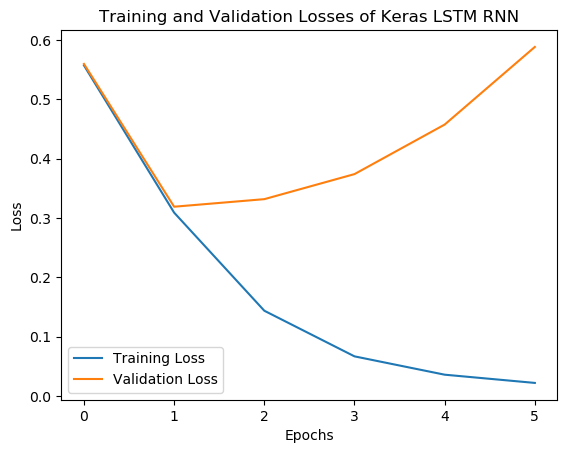

In [51]:
num_epochs = 20

start_time = time.time()

LSTM_RNN_training_history = LSTM_RNN.fit(X_train, 
                                         Y_train, 
                                         validation_data = (X_validation, Y_validation), 
                                         epochs = num_epochs, 
                                         batch_size = batch_size,
                                         callbacks = callbacks)

# print train time
elapsed_time = ((time.time() - start_time) / 60)
print()
print("Elapsed model training time:\n{:.2f} minutes".format(elapsed_time))

# plot loss curves
plt.figure()
plt.plot(LSTM_RNN_training_history.history["loss"], label = "Training Loss")
plt.plot(LSTM_RNN_training_history.history["val_loss"], label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Losses of Keras LSTM RNN")
plt.legend()
plt.show()


*Note: The training and validation loss curves diverge towards then end of the training, but since I am saving and then later restoring the model with the best performing weights, the divergence is not a concern.*

#### 6. Calculate and report the performance of your model on the training and test set. 15 points
- Calculate the accuracies on the training and test sets
- Print out the confusion matrix of model results on the test set: https://scikit-learn.org/dev/modules/generated/sklearn.metrics.confusion_matrix.html

In [53]:
# reload best model

LSTM_RNN = load_model("Best_Model.h5")

# evaluate model

Y_train_hat = LSTM_RNN.predict(X_train)
Y_test_hat = LSTM_RNN.predict(X_test)
Y_train_hat = (Y_train_hat > 0.5).astype(int)
Y_test_hat = (Y_test_hat > 0.5).astype(int)

train_accuracy = accuracy_score(Y_train, Y_train_hat)
test_accuracy = accuracy_score(Y_test, Y_test_hat)

print()

# print accuracies using accuracy score

print("Using accuracy score:")
print()
print("Training accuracy:", train_accuracy)
print("Test accuracy:", test_accuracy)
print()

# print accuracies using evaluate

train_loss, train_accuracy = LSTM_RNN.evaluate(X_train, Y_train)
test_loss, test_accuracy = LSTM_RNN.evaluate(X_test, Y_test)

print()
print("Using evaluate:")
print()
print("Training accuracy:", train_accuracy)
print("Test accuracy:", test_accuracy)
#print("Training loss", train_loss)
#print("Test loss", test_loss)
print()

# confusion matrices

print("Confusion matrix for train set:\n", confusion_matrix(Y_train, Y_train_hat))
print()
print("Confusion matrix for test set:\n", confusion_matrix(Y_test, Y_test_hat))
print()


469/469 [==============================] - 21s 45ms/step

Using accuracy score:

Training accuracy: 0.95344
Test accuracy: 0.8784

469/469 [==============================] - 21s 46ms/step - loss: 0.3069 - accuracy: 0.8784

Using evaluate:

Training accuracy: 0.9534400105476379
Test accuracy: 0.8784000277519226

Confusion matrix for train set:
 [[11736   703]
 [  461 12100]]

Confusion matrix for test set:
 [[6434 1089]
 [ 735 6742]]

